### Experiment Design

#### Required Input
1. An implementation of a $(\epsilon_\text{true}, \delta=0)-$DP laplace mechanism $M$ whose true $\epsilon_\text{true}$ is unknown in practical applications. However, for the purposes of this experiment, $\epsilon_\text{true}$ will be an input.
2. The claimed value of epsilon, $\epsilon_\text{claimed}$.

#### Optional Input
1. Bootstrap Confidence Probability, $p$ $99\%$ by default.
2. Statistical distance estimation algorithm inputs, Section 7 of the draft.

#### Output
1. One of three results (each with probability $p$): the claimed epsilon is correct ($\epsilon_\text{true}\approx\epsilon_\text{correct}$), the claimed epsilon is too high ($\epsilon_\text{claimed} > \epsilon_\text{true}$), the claimed epsilon is too low ($\epsilon_\text{claimed} < \epsilon_\text{true}$).

####  Method

The statistical distance estimation algorithm take a sample generation algorithm (i.e. a way of sampling from the 'positive' and 'negative' distributions) in as input. Recall that a sample is a feature vector $X\in R^d$ and a label $y\in\{0,1\}$.

1. Sample Generation Algorithm ([python implementation](https://github.com/maksimt/empirical_privacy/blob/master/src/empirical_privacy/laplace_mechanism.py#L14)) for the Laplace mechanism DP verification experiment:
  1. Assume that negative samples start with pre-noise query output $X_0=(0,0,0)$, $y=0$.
  2. Assume that positive samples start with pre-noise query output $X_1=(1,0,0)$, $y=1$.
  3. Assume that the query sensitivity is $\Delta f=1$.
  3. Repeat for each sample:
    1. Draw $y \sim B\left(n=1, p=0.5\right)$, where $B$ is the binomial distribution.
    2. If $y=0$, **return** $X=X_0 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$ and $y=0$, otherwise continue.
    1. Draw $c \sim B\left(n=1, p=\frac{1}{\epsilon_\text{claimed}}\right)$.
    2. If $c=1$, **return** $X=X_1 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$ and $y=1$, otherwise continue.
    3. **return** $X=\bot$ and $y=1$.
       4. To simplify implementation we define $\bot=X_1-1000(\frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}})$; this $\bot$ has a probability of approximately $e^{-1000}$ of being generated by $X_1 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$.
  
2. The statistical distance estimation algorithm outputs a lower bound and upper bound on the statistical distance, $\Delta_\text{lb}, \Delta_\text{ub}$. Compute the bounds for the differential privacy delta lower and upper bounds as
$$\delta_\text{lb,ub}=e^{\epsilon_\text{claimed}} \left(\Delta_\text{lb,ub} - \left(1-\frac{1}{e^{\epsilon_\text{claimed}}}\right)\right).$$

3. Output the decision.
  1. If $\delta_\text{lb} < 0 < \delta_\text{ub}$ **return** $\epsilon_\text{claimed} \approx \epsilon_\text{true}$.
  2. If $\delta_\text{ub} < 0$ **return** $\epsilon_\text{claimed} > \epsilon_\text{true}$.
  3. If $\delta_\text{lb} > 0$ **return** $\epsilon_\text{claimed} < \epsilon_\text{true}$.

### Experiment

We set $\epsilon_\text{claimed} = \epsilon_\text{true} = 0.1$, and as a result we expect the output to be $\epsilon_\text{claimed} \approx \epsilon_\text{true}$, which means we need $\delta_\text{lb} < 0 < \delta_\text{ub}$.

We set the bootstrap probability $p=0.99$.

We repeat the experiment for `n_docs=100` trials, and expect approximately $p\times$ `n_docs` $=99$ of them to be successful.

### Experiment Outcomes

Right now the experiments are failing because far fewer than 99 trials satisfy $\delta_\text{lb} < 0 < \delta_\text{ub}$.

In [1]:
import itertools
import os
from collections import namedtuple
from math import exp

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.utils.helpers import (AllAsymptotics, AllDeltas)
from notebook_context.pandas_interface import load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe
from empirical_privacy import laplace_mechanism, config

from notebook_context import *
%matplotlib inline

In [7]:
epsilons = [
    0.001,
    0.01,
#     0.1,
    1.0,
#     10.0
]
multipliers=[0.9, 1.0, 1.1]
dses = [{
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'delta'      : 0.
} for eps in epsilons]

asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack',
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 10,
    'n_trials_per_training_set_size': 300,
    'min_samples'        : 2**10,
    'n_max'              : 2**11,
    'validation_set_size': 2**14,
    'p'                  : 0.99,  # for bootstrap
    'n_bootstraps'       : 100000,  # for bootstrap
    'in_memory'          : True
}

d = 3

In [8]:
CCCs = dict()
Alls = dict()
AAs = dict()
CLBDs = dict()

experiment = namedtuple('Experiment', ['eps', 'claimed_eps'])

for (i, ds) in enumerate(dses):
    eps = epsilons[i]
    for CLAIMED_EPS in [eps*multi for multi in multipliers]:
        expm = experiment(eps, CLAIMED_EPS)
        All = AllDeltas(
                gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
                dataset_settings=ds,
                asymptotic_settings=asys,
                claimed_epsilon=CLAIMED_EPS
        )
        Alls[expm] = All
        CLBDs[expm] = All.requires()
        AAs[expm] = [CLBD.requires()['asymptotic_accuracy'] for CLBD in CLBDs[expm]]
        CCCs[expm] = [AA.requires()['CCC'] for AA in AAs[expm]]
    

In [25]:
#uncomment this to recompute the top level tasks

# for AA in AAs[eps]:
#     AA.delete_outputs()
# for clbd in CLBDs[eps]:
#     clbd.delete_outputs()

In [9]:
luigi.build([All for All in Alls.values()], workers=3, log_level='ERROR',
#             local_scheduler=True
           )

True

### Plot outcomes for all trials

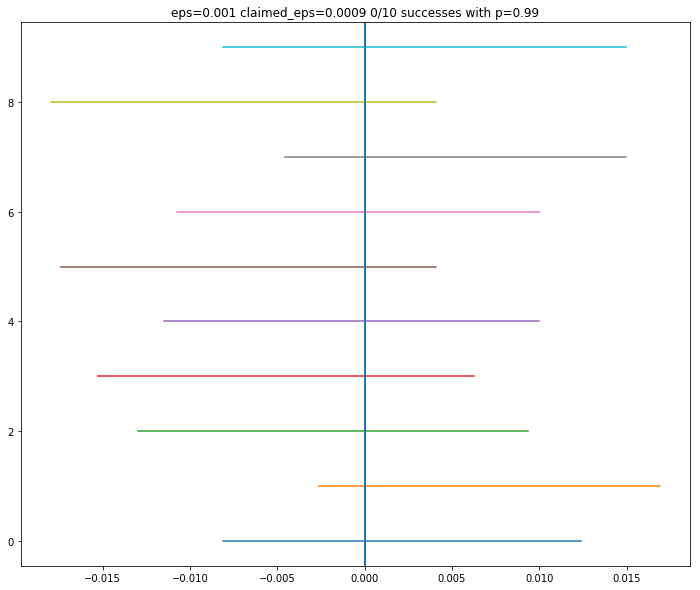

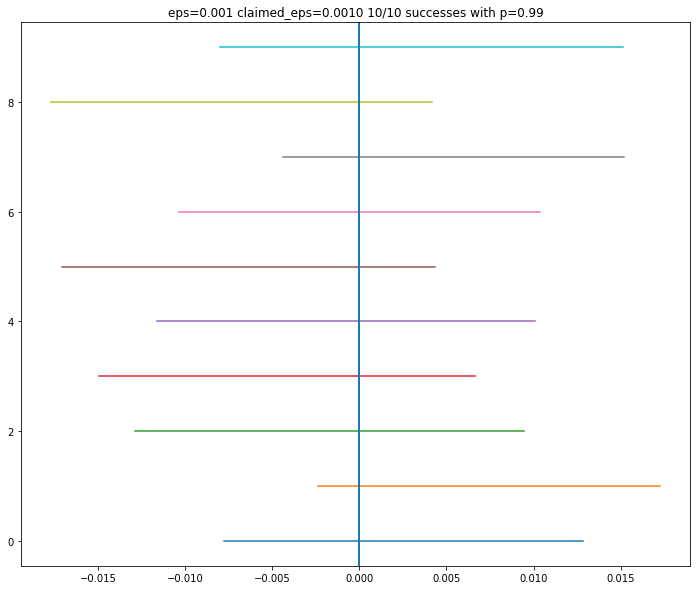

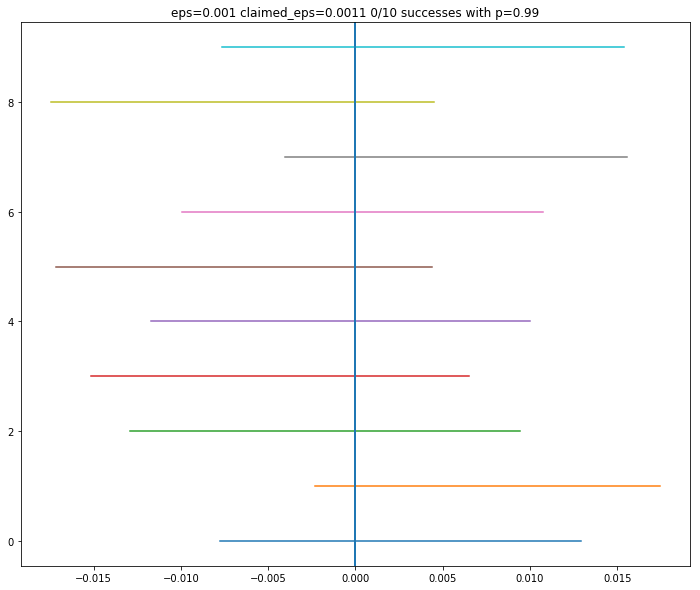

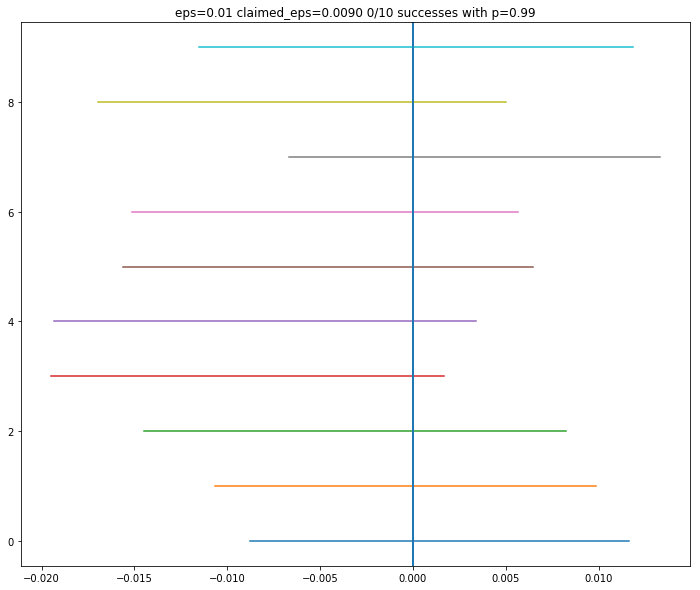

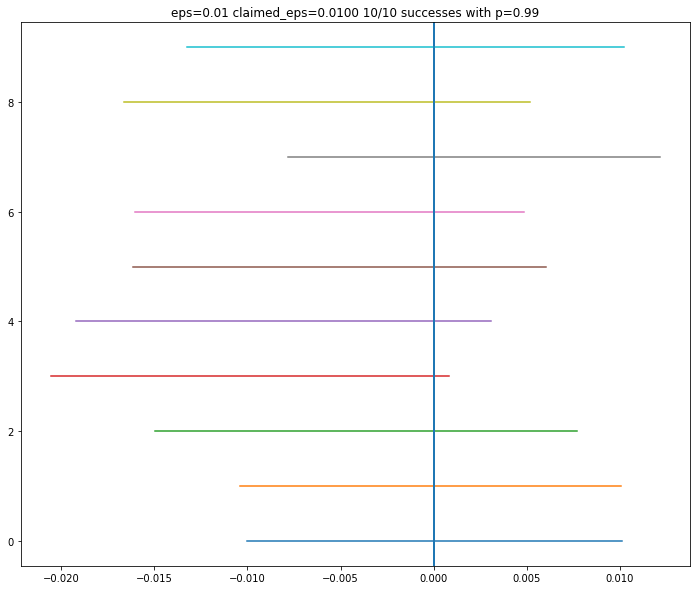

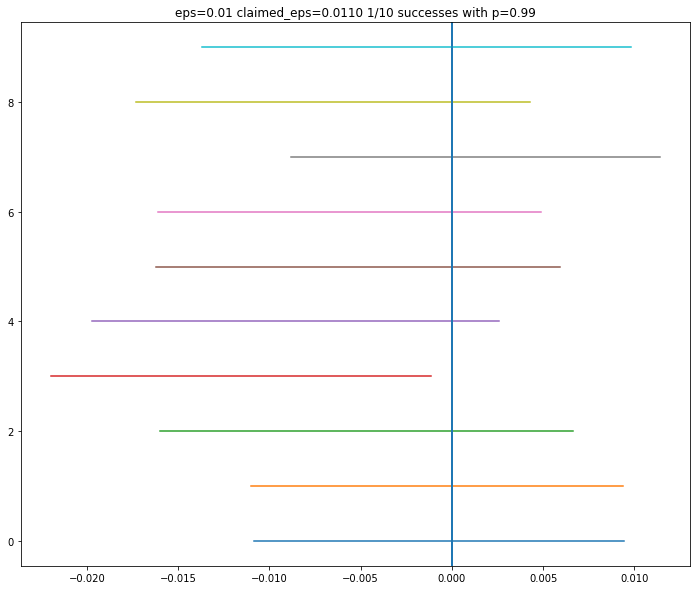

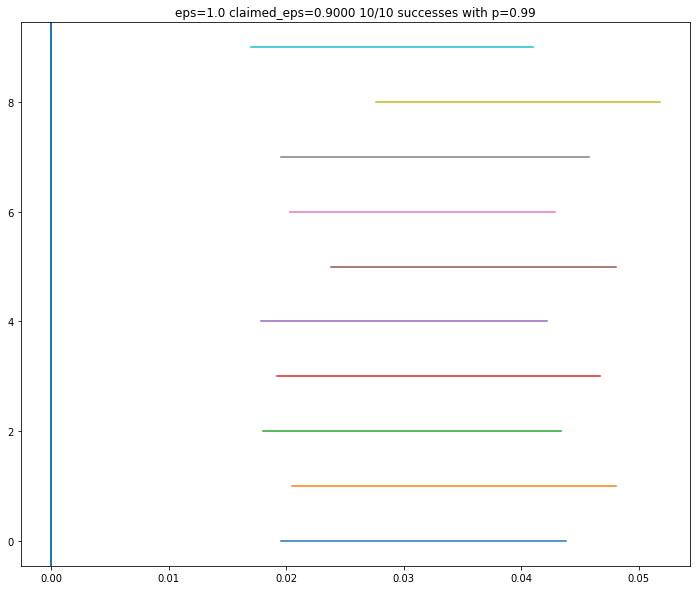

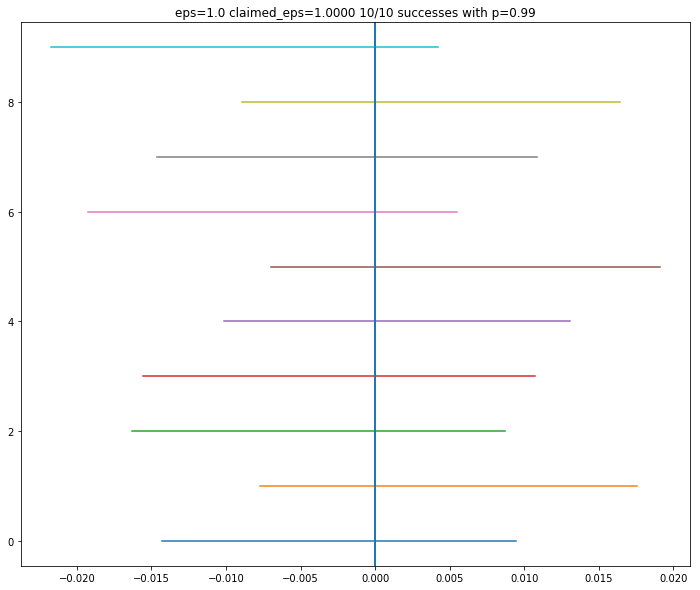

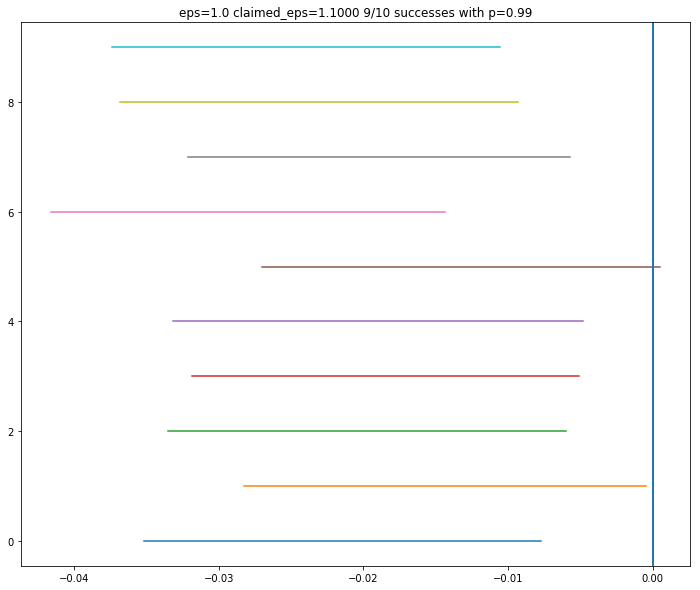

In [6]:
def success(delta_lb, delta_ub, eps, claimed_eps):
    if claimed_eps == eps:
        return 1 if delta_lb < 0 < delta_ub else 0
    if claimed_eps > eps:
        return 1 if delta_ub < 0 else 0
    if claimed_eps < eps:
        return 1 if delta_lb > 0 else 0

def plot_eps(expm, CLAIMED_EPS):
    try:
        AAs = Alls[expm].requires()
    except KeyError:
        return
    DF = load_completed_AAs_into_dataframe(AAs)
    eps, CLAIMED_EPS = expm.eps, expm.claimed_eps
    plt.figure(figsize=(12,10))
    n_trials = 0
    n_successes = 0
    for (i,CLBD) in enumerate(AAs):
        with CLBD.output().open() as f:
            deltas = dill.load(f)
            n_trials += 1
            n_successes += success(deltas['lower_bound'],
                                   deltas['upper_bound'],
                                   eps=eps,
                                   claimed_eps=CLAIMED_EPS)
    #         print(i, deltas)
            plt.plot([deltas['lower_bound'], deltas['upper_bound']], [i, i])
        plt.axvline(0)
    plt.title(f'eps={eps} claimed_eps={CLAIMED_EPS:.4f}'
              f' {n_successes}/{n_trials} successes with p={asys["p"]:.2f}')

    
for expm in sorted(Alls.keys(),key=lambda expm: expm.eps):
    plot_eps(expm, CLAIMED_EPS)

In [18]:
eps=0.001
CLAIMED_EPS = eps
probability_of_natural_sample = 1 / (exp(CLAIMED_EPS))
probability_of_alternative_sample = 1 - probability_of_natural_sample
expected_accuracy = 0.5 + 0.5 * probability_of_alternative_sample
print(probability_of_natural_sample)
print(expected_accuracy)

0.9990004998333749
0.5004997500833126


In [9]:
n_total = 0
n_successes = 0
for AA in [CLBD.requires()['asymptotic_accuracy'] for CLBD in CLBDs[eps]]:
    with AA.output().open() as f:
        aa = dill.load(f)
#         print(aa)
        n_total += 1
        n_successes += 1 if aa['lower_bound'] < expected_accuracy < aa['upper_bound'] else 0
print(f"""Success probability {n_successes/n_trials:.2f} over {n_trials} trials
with bootstrap confindence interval probability of {asys["p"]:.2f}.""")

Success probability 0.42 over 100 trials
with bootstrap confindence interval probability of 0.99.


In [ ]:
configure_plotting_for_publication()

SAVE_FIGURES_FOR_LATEX = False


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p_two_sided, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

In [ ]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

confidence_interval_width = 0.01
confidence_interval_prob = 0.9
    
def plot_convergence_curve_dataframe(DF, doc_ind=None, d=3):
    global SAVE_FIGURES_FOR_LATEX
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
#     DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    DF.drop(index=DF[DF.classifier_accuracy < 0.5].index, inplace=True)
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    d=3
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    m, C = asymptotic_curve(ks, y)
    print(f'm={m} C={C}')
    
    # bootstrap for ub
    boot_res = compute_bootstrapped_upper_bound(x, d, fit_model, y,
                                 confidence_interval_prob,
                                 confidence_interval_width)
    samples = boot_res['bootstrap_samples'] 
    
    ub = boot_res['ub']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
#     labeled_axhline(pc(eps, delta), '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 1)


In [ ]:
from functools import partial

from experiment_framework.asymptotic_analysis import bootstrap_ci, asymptotic_privacy_lr
from experiment_framework.differential_privacy import compute_delta
from experiment_framework.calculations import accuracy_to_statistical_distance

def get_bootstrap_model(DF, doc_ind, d= 3):
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    n_docs = DF.doc_ind.nunique()
    
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    return {'training_set_sizes':x, 'y':y, 'fit_model':fit_model, 'ks':ks}

DFccc[DFccc.classifier_accuracy < 0.5] = 0.5
model = get_bootstrap_model(DFccc, 0)
accuracy_results = np.array([])


# results = more_results(model, 10)
# a

In [ ]:
results = bootstrap_ci(
    10000,
    X=model['training_set_sizes'],
    y=model['y'],
    f=partial(asymptotic_privacy_lr, fit_model=model['fit_model'], d=d),
    random_state_offset=accuracy_results.size
)
accuracy_results = np.concatenate((accuracy_results, results))
deltas = np.array([compute_delta(stat_dist=accuracy_to_statistical_distance(accu), epsilon=CLAIMED_EPS)
                   for accu in accuracy_results])
_ = plt.hist(deltas)
alpha = (1-0.999)/2 * 100.0
lb = np.percentile(deltas, alpha)
ub = np.percentile(deltas, 100-alpha)
plt.axvline(lb, color='r')
plt.axvline(ub, color='r')
plt.axvline(0, color='k')
plt.axvline(np.mean(deltas), color='g')

In [ ]:
bootstrap_xs = np.logspace(1, np.log2(deltas.size), base=2).astype(np.int)

In [ ]:
plt.plot(bootstrap_xs, [np.std(deltas[0:i]) for i in bootstrap_xs], '-*r')
plt.title('std as a function of bootstrap samples')

In [ ]:
def bootstrap_t(samples):
    